I implement the previous code on a larger corpus and possibly real-valued model (word2vec)

In [30]:
using TextAnalysis
using Random 
sampled_articles = readlines("wiki_20.txt")
# Tokenize and clean text
function preprocess(text)
    text = lowercase(text)
    tokens = filter(t -> length(t) > 1, split(replace(text, r"[^\w\s]" => " "), " "))  # Remove punctuation
    return tokens
end

# Preprocess all sampled articles
corpus = [preprocess(article) for article in sampled_articles]

20-element Vector{Vector{SubString{String}}}:
 ["the", "federalist", "papers", "is", "collection", "of", "articles", "and", "essays", "written"  …  "in", "the", "broadway", "musical", "hamilton", "written", "by", "lin", "manuel", "miranda"]
 ["centre", "county", "is", "county", "in", "the", "commonwealth", "of", "pennsylvania", "united"  …  "is", "based", "on", "the", "census", "of", "centre", "county", "county", "seat"]
 ["edith", "of", "england", "also", "spelt", "eadgyth", "or", "ædgyth", "member", "of"  …  "in", "her", "tomb", "at", "magdeburg", "cathedral", "on", "october", "external", "links"]
 ["kick", "start", "is", "the", "task", "of", "using", "the", "foot", "to", "start", "motorcycle", "the", "term", "may", "also", "refer", "to"]
 ["agronomy", "generally", "known", "as", "agriculture", "is", "the", "science", "and", "technology"  …  "crop", "biomass", "plant", "production", "distribution", "and", "nutrient", "and", "water", "supply"]
 ["scientific", "visualization", "also", 

In [31]:
# buidling our vocabulary from the corpus, but we include all words no minimum count
vocab = unique(vcat(corpus...))
vocab_size = length(vocab)
word_to_idx = Dict(word => idx for (idx, word) in enumerate(vocab))
corpus_to_idx = [[word_to_idx[word] for word in doc] for doc in corpus] 

20-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  35, 1, 903, 904, 13, 10, 11, 905, 906, 907]
 [908, 909, 4, 909, 35, 1, 910, 6, 659, 26  …  4, 323, 128, 1, 911, 6, 908, 909, 909, 913]
 [1224, 6, 1225, 170, 1226, 1227, 115, 1228, 424, 6  …  35, 1234, 1389, 243, 1290, 1297, 128, 53, 1433, 1434]
 [1435, 739, 4, 1, 1436, 6, 1437, 1, 1438, 22, 739, 1439, 1, 1440, 71, 170, 1441, 22]
 [1442, 554, 30, 31, 1443, 4, 1, 213, 8, 1444  …  1488, 1733, 1453, 457, 1734, 8, 1661, 8, 972, 1735]
 [1509, 1736, 170, 1737, 1509, 1738, 4, 147, 1739, 6  …  1043, 11, 2246, 35, 1509, 1736, 1452, 112, 1933, 676]
 [1, 2247, 2248, 28, 2249, 1033, 243, 344, 345, 422  …  2350, 243, 345, 126, 1, 2284, 6, 1, 53, 2351]
 [28, 1153, 1391, 35, 1, 2352, 1084, 6, 2353, 2354  …  87, 28, 2362, 305, 920, 6, 1, 1145, 2357, 2358]
 [1, 1230, 1053, 1806, 2374, 4, 485, 1663, 2028, 448  …  1806, 2386, 1739, 4, 2032, 35, 2955, 269, 2956, 1325]
 [40, 2957, 6, 1, 1288, 2958, 98, 94, 518, 2959  …  2965, 2957, 518, 2

# Complex Model

SGD - decaying learning rate (lr_t = max(lr * decay^(epoch - 1), min_lr))

In [ ]:
using Random, Statistics, LinearAlgebra

function init_complex_params(vocab_size, dim)
    r = randn(vocab_size, dim) 
    θ = (rand(vocab_size) .- 0.5) 
    return r, θ
end

function sigmoid(x)
    if x ≥ 0
        z = exp(-x)
        return 1 / (1 + z)
    else
        z = exp(x)
        return z / (1 + z)
    end
end

function embed(r, θ, idx)
    mag = r[idx, :]
    phase = θ[idx]
    real_part = mag .* cos.(phase)
    imag_part = mag .* sin.(phase)
    return real_part, imag_part
end

function real_inner(xr, xi, yr, yi)
    return sum(xr .* yr) + sum(xi .* yi)
end

function get_negatives(vocab_size, true_idx, k)
    samples = Int[]
    while length(samples) < k
        idx = rand(1:vocab_size)
        if idx != true_idx
            push!(samples, idx)
        end
    end
    return samples
end

function train_complex(corpus, vocab_size, dim;
        window=5, epochs=50, lr=0.01, min_lr=1e-5, decay=0.97,
        neg_samples=5, λ_center=1, λ_var=1)

    r, θ = init_complex_params(vocab_size, dim)
    losses = Float64[]

    for epoch in 1:epochs
        total_loss = 0.0
        lr_t = max(lr * decay^(epoch - 1), min_lr)

        for doc in corpus
            for i in 1:length(doc)
                w = doc[i]
                for j in max(1, i - window):min(length(doc), i + window)
                    if i == j
                        continue
                    end
                    c = doc[j]

                    r_w, θ_w = embed(r, θ, w)
                    r_c, θ_c = embed(r, θ, c)
                    score = real_inner(r_w, θ_w, r_c, θ_c)
                    loss_pos = -log(sigmoid(score))
                    g_pos = sigmoid(score) - 1

                    r[w, :] .-= lr_t * g_pos .* cos.(θ[w] .- θ[c]) .* r[c, :]
                    r[c, :] .-= lr_t * g_pos .* cos.(θ[w] .- θ[c]) .* r[w, :]

                    θ[w] -= lr_t * g_pos * sum(r[w, :] .* r[c, :] .* sin.(θ[c] .- θ[w]))
                    θ[c] -= lr_t * g_pos * sum(r[w, :] .* r[c, :] .* sin.(θ[w] .- θ[c]))

                    total_loss += loss_pos

                    for neg in get_negatives(vocab_size, c, neg_samples)
                        r_neg, θ_neg = embed(r, θ, neg)
                        score_neg = real_inner(r_w, θ_w, r_neg, θ_neg)
                        loss_neg = -log(sigmoid(-score_neg))
                        g_neg = sigmoid(score_neg)

                        r[w, :] .-= lr_t * g_neg .* cos.(θ[neg] .- θ[w]) .* r[neg, :]
                        r[neg, :] .-= lr_t * g_neg .* cos.(θ[w] .- θ[neg]) .* r[w, :]

                        θ[w] -= lr_t * g_neg * sum(r[w, :] .* r[neg, :] .* sin.(θ[neg] .- θ[w]))
                        θ[neg] -= lr_t * g_neg * sum(r[w, :] .* r[neg, :] .* sin.(θ[w] .- θ[neg]))

                        total_loss += loss_neg
                    end
                end
            end
        end

        # Regularization terms
        θ_mean = mean(θ)
        θ_var = mean(θ .^ 2) - θ_mean^2
        sin_mean = mean(sin.(θ))

        total_loss += λ_var * θ_var
        total_loss += λ_center * sin_mean^2

        grad_Lvar = (2 * λ_var / length(θ)) .* (θ .- θ_mean)
        grad_Lcent = (2 * λ_center / length(θ)) * sin_mean .* cos.(θ)

        θ .-= lr_t .* (grad_Lvar .+ grad_Lcent)
        push!(losses, total_loss)
        println("Epoch $epoch | Loss: $total_loss | LR: $lr_t | Phase range: ($(minimum(θ)), $(maximum(θ)))")
    end

    return r, θ, losses 
end

# Train complex model
complex_r, complex_θ, complex_losses = train_complex(corpus_to_idx, vocab_size, 100,
    window=5, epochs=100, lr=0.01, min_lr=1e-5, decay=0.97,
    neg_samples=5, λ_center=0.05, λ_var=0.05)

Epoch 1 | Loss: 2.9944577791740694e6 | LR: 0.01 | Phase range: (-3.369838218761318, 3.312186476909686)
Epoch 2 | Loss: 2.261116169653247e6 | LR: 0.0097 | Phase range: (-3.300463430561058, 3.63146122765433)
Epoch 3 | Loss: 1.9837610783494168e6 | LR: 0.009408999999999999 | Phase range: (-3.46046685881514, 3.6557679438613655)
Epoch 4 | Loss: 1.8177594568718192e6 | LR: 0.00912673 | Phase range: (-3.3201014358482897, 3.673877311275925)
Epoch 5 | Loss: 1.7046420421588935e6 | LR: 0.008852928099999999 | Phase range: (-3.501046617961608, 3.5962265575736776)
Epoch 6 | Loss: 1.61676550663996e6 | LR: 0.008587340257 | Phase range: (-3.55891754441925, 3.4720155686742173)
Epoch 7 | Loss: 1.5432176108978444e6 | LR: 0.008329720049289998 | Phase range: (-3.2616317152860006, 3.6478762271549745)
Epoch 8 | Loss: 1.4763987939069816e6 | LR: 0.008079828447811297 | Phase range: (-3.067090989525107, 3.6505005286003542)
Epoch 9 | Loss: 1.4204805160335053e6 | LR: 0.007837433594376959 | Phase range: (-3.2367822062

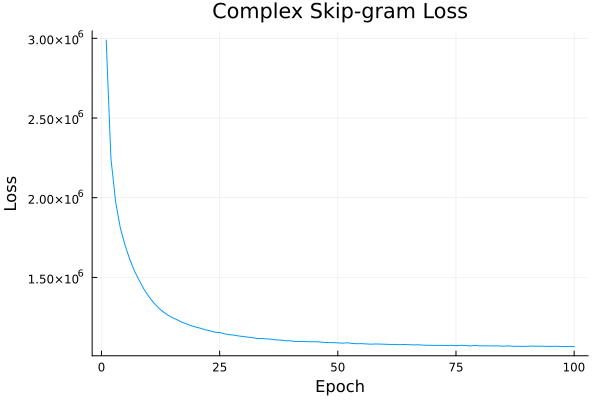

In [33]:
using Plots
plot(complex_losses, xlabel="Epoch", ylabel="Loss", title="Complex Skip-gram Loss", legend=false)

## Complex Model Evaluation

In [34]:
using LinearAlgebra

# Convert to real embeddings
complex_real_embeddings = complex_r .* cos.(complex_θ)

function cosine_similarity(x, y)
    xy_dot = dot(x, y)
    x_norm = norm(x)
    y_norm = norm(y)
    return xy_dot / (x_norm * y_norm + 1e-8)
end

function evaluate_similarity(embeddings, word_to_idx, pairs)
    results = []
    for (w1, w2) in pairs
        if haskey(word_to_idx, w1) && haskey(word_to_idx, w2)
            v1 = embeddings[word_to_idx[w1], :]
            v2 = embeddings[word_to_idx[w2], :]
            sim = cosine_similarity(v1, v2)
            push!(results, (w1, w2, sim))
        else
            push!(results, (w1, w2, "MISSING"))
        end
    end
    return results
end

function evaluate_analogy(embeddings, word_to_idx, quads; top_n=5, verbose=true)
    results = []
    correct_count = 0
    
    for (a, b, c, d) in quads
        if all(haskey(word_to_idx, w) for w in [a,b,c,d])
            va = embeddings[word_to_idx[a], :]
            vb = embeddings[word_to_idx[b], :]
            vc = embeddings[word_to_idx[c], :]
            target = vb - va + vc
            
            candidates = Tuple{String,Float64}[]
            for (word, idx) in word_to_idx
                if word ∉ [a,b,c,d]
                    candidate = embeddings[idx, :]
                    sim = cosine_similarity(target, candidate)
                    push!(candidates, (word, sim))
                end
            end
            
            sort!(candidates, by=x->x[2], rev=true)
            top_preds = candidates[1:min(top_n, length(candidates))]
            is_correct = !isempty(top_preds) && top_preds[1][1] == d
            
            if is_correct
                correct_count += 1
            end
            
            push!(results, (a, b, c, d, top_preds, is_correct))
            
            if verbose
                println("\n", rpad("$a : $b :: $c :", 25), d)
                println("Top predictions:")
                for (i, (word, score)) in enumerate(top_preds)
                    println(rpad("$i. $word", 15), "(", round(score, digits=3), ")",
                          word == d ? " ✓" : "")
                end
                println("Correct: ", is_correct)
            end
        else
            missing_words = [w for w in [a,b,c,d] if !haskey(word_to_idx, w)]
            push!(results, (a, b, c, d, "MISSING: $(join(missing_words, ", "))", false))
            
            if verbose
                println("\n", rpad("$a : $b :: $c :", 25), d)
                println("MISSING WORDS: ", join(missing_words, ", "))
            end
        end
    end
    
    accuracy = correct_count / length(quads)
    return results, accuracy
end

# Test data
valid_pairs = [("federalist", "papers"), ("county", "seat"), ("royal", "navy")]
test_quads = [("federalist", "papers", "royal", "navy"),
              ("county", "seat", "city", "ward")]
analogy_triples = [
    ("king", "man", "woman", "queen"),
    ("paris", "france", "germany", "berlin"),
    ("walking", "walked", "run", "ran")
]

# Run complex model evaluation
println("="^60)
println("COMPLEX MODEL EVALUATION")
println("="^60)

println("\nWORD SIMILARITY:")
complex_sim_results = evaluate_similarity(complex_real_embeddings, word_to_idx, valid_pairs)
for (w1, w2, sim) in complex_sim_results
    println(rpad("$w1 - $w2:", 25), sim isa String ? sim : round(sim, digits=3))
end

println("\nANALOGY EVALUATION:")
complex_analogy_results, complex_accuracy = evaluate_analogy(complex_real_embeddings, word_to_idx, vcat(test_quads, analogy_triples))
println("\nOverall Accuracy: ", round(complex_accuracy*100, digits=1), "%")

COMPLEX MODEL EVALUATION

WORD SIMILARITY:
federalist - papers:     0.818
county - seat:           0.316
royal - navy:            0.72

ANALOGY EVALUATION:

federalist : papers :: royal :navy
Top predictions:
1. fleet       (0.529)
2. progressive (0.512)
3. percent     (0.51)
4. week        (0.504)
5. vote        (0.496)
Correct: false

county : seat :: city :  ward
Top predictions:
1. redmonton   (0.458)
2. percent     (0.436)
3. edmonton    (0.433)
4. liberal     (0.431)
5. voting      (0.409)
Correct: false

king : man :: woman :    queen
Top predictions:
1. buried      (0.436)
2. gore        (0.389)
3. having      (0.361)
4. mancha      (0.349)
5. distinguished(0.341)
Correct: false

paris : france :: germany :berlin
MISSING WORDS: berlin

walking : walked :: run :ran
MISSING WORDS: walking, walked

Overall Accuracy: 0.0%


# Standard (real) Skipgram Model

SGD learning rate (lr_epoch = max(lr * decay^(epoch - 1), min_lr))

In [37]:
using Random, Statistics, LinearAlgebra, Printf

function init_embeddings(vocab_size, embedding_dim)
    W = randn(vocab_size, embedding_dim) * 0.01
    C = randn(vocab_size, embedding_dim) * 0.01
    return W, C
end

function sigmoid(x)
    1 / (1 + exp(-x))
end

function get_negative_samples(vocab_size, target, k)
    samples = Int[]
    while length(samples) < k
        neg = rand(1:vocab_size)
        if neg != target
            push!(samples, neg)
        end
    end
    return samples
end

function train_skipgram(corpus, vocab_size, embedding_dim;
                        window_size=2, epochs=100, lr=0.1, min_lr=1e-4,
                        neg_samples=5, decay=0.97)

    W, C = init_embeddings(vocab_size, embedding_dim)
    losses = Float64[]

    for epoch in 1:epochs
        total_loss = 0.0
        lr_epoch = max(lr * decay^(epoch - 1), min_lr)

        for sentence in corpus
            for i in 1:length(sentence)
                center = sentence[i]
                context_range = max(1, i - window_size):min(length(sentence), i + window_size)
                for j in context_range
                    if i == j
                        continue
                    end
                    context = sentence[j]

                    # Positive pair
                    score = dot(W[center, :], C[context, :])
                    pos_loss = -log(sigmoid(score))
                    grad = sigmoid(score) - 1
                    W[center, :] .-= lr_epoch * grad * C[context, :]
                    C[context, :] .-= lr_epoch * grad * W[center, :]
                    total_loss += pos_loss

                    # Negative samples
                    for neg in get_negative_samples(vocab_size, context, neg_samples)
                        score = dot(W[center, :], C[neg, :])
                        neg_loss = -log(sigmoid(-score))
                        grad = sigmoid(score)
                        W[center, :] .-= lr_epoch * grad * C[neg, :]
                        C[neg, :] .-= lr_epoch * grad * W[center, :]
                        total_loss += neg_loss
                    end
                end
            end
        end
        push!(losses, total_loss)
        println("Epoch $epoch | Loss: $total_loss | LR: $lr_epoch")
    end

    return W + C, losses
end

# Train skipgram model
skipgram_embeddings, skipgram_losses = train_skipgram(corpus_to_idx, vocab_size, 100,
    window_size=5, epochs=100, lr=0.01, min_lr=1e-5, decay=0.97,
    neg_samples=5)

Epoch 1 | Loss: 1.0227417673179515e6 | LR: 0.01
Epoch 2 | Loss: 733427.882429533 | LR: 0.0097
Epoch 3 | Loss: 623411.0503319105 | LR: 0.009408999999999999
Epoch 4 | Loss: 572337.0927852783 | LR: 0.00912673
Epoch 5 | Loss: 545824.0218101725 | LR: 0.008852928099999999
Epoch 6 | Loss: 529969.5610311588 | LR: 0.008587340257
Epoch 7 | Loss: 520242.97654518264 | LR: 0.008329720049289998
Epoch 8 | Loss: 513386.08112038625 | LR: 0.008079828447811297
Epoch 9 | Loss: 507946.99313336867 | LR: 0.007837433594376959
Epoch 10 | Loss: 503251.68852984195 | LR: 0.007602310586545651
Epoch 11 | Loss: 499362.11159993144 | LR: 0.007374241268949281
Epoch 12 | Loss: 495640.1419026832 | LR: 0.007153014030880802
Epoch 13 | Loss: 491397.7248558946 | LR: 0.006938423609954378
Epoch 14 | Loss: 487800.92604928155 | LR: 0.006730270901655747
Epoch 15 | Loss: 483963.7340863952 | LR: 0.006528362774606074
Epoch 16 | Loss: 481075.12054081366 | LR: 0.006332511891367892
Epoch 17 | Loss: 476147.1680458525 | LR: 0.00614253653

([0.768376424548392 0.630574668419353 … -0.454589125882143 0.02551441284810571; 0.4338432943741602 -0.006742442897145913 … -0.007078703459273722 -0.48206133128735973; … ; -0.2097975175958688 -0.3695062458635682 … -0.3911597582559598 -0.06745105306059901; -0.11061723105398873 -0.1981661506174595 … 0.08336503954329416 -0.037731531154720624], [1.0227417673179515e6, 733427.882429533, 623411.0503319105, 572337.0927852783, 545824.0218101725, 529969.5610311588, 520242.97654518264, 513386.08112038625, 507946.99313336867, 503251.68852984195  …  353814.90008186613, 353586.0198161305, 353965.3244941517, 353080.83695140254, 352437.8678717264, 351812.3307475666, 352056.76475954783, 351479.70347613614, 351694.8380472487, 351050.1779382257])

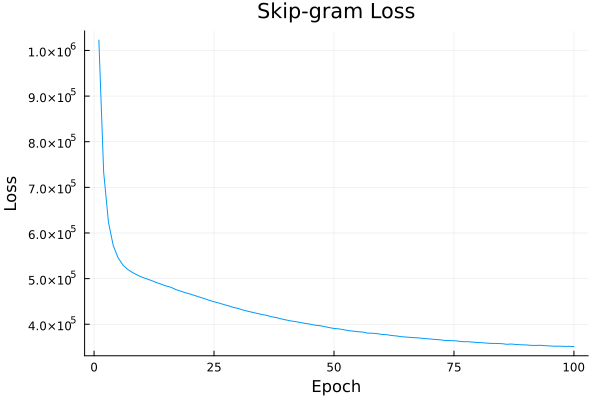

In [41]:
using Plots
plot(skipgram_losses, xlabel="Epoch", ylabel="Loss", title="Skip-gram Loss", legend=false)

## Skipgram Model Evaluation

In [42]:
using LinearAlgebra

function evaluate_similarity(embeddings, word_to_idx, word_pairs; verbose=true)
    results = []
    for (w1, w2) in word_pairs
        if haskey(word_to_idx, w1) && haskey(word_to_idx, w2)
            v1 = embeddings[word_to_idx[w1], :]
            v2 = embeddings[word_to_idx[w2], :]
            sim = cosine_similarity(v1, v2)
            push!(results, (w1, w2, sim))
            
            if verbose
                println(rpad("$w1 - $w2", 25), "Similarity: ", round(sim, digits=3))
            end
        else
            missing_words = [w for w in [w1, w2] if !haskey(word_to_idx, w)]
            push!(results, (w1, w2, "MISSING: $(join(missing_words, ", "))"))
            
            if verbose
                println(rpad("$w1 - $w2", 25), "MISSING WORDS: ", join(missing_words, ", "))
            end
        end
    end
    return results
end

function evaluate_analogy(embeddings, word_to_idx, quads; top_n=5, verbose=true)
    results = []
    correct_count = 0
    
    for (a, b, c, d) in quads
        if all(haskey(word_to_idx, w) for w in [a,b,c,d])
            va = embeddings[word_to_idx[a], :]
            vb = embeddings[word_to_idx[b], :]
            vc = embeddings[word_to_idx[c], :]
            target = vb - va + vc
            
            candidates = Tuple{String,Float64}[]
            for (word, idx) in word_to_idx
                if word ∉ [a,b,c,d]
                    candidate = embeddings[idx, :]
                    sim = cosine_similarity(target, candidate)
                    push!(candidates, (word, sim))
                end
            end
            
            sort!(candidates, by=x->x[2], rev=true)
            top_preds = candidates[1:min(top_n, length(candidates))]
            is_correct = !isempty(top_preds) && top_preds[1][1] == d
            
            if is_correct
                correct_count += 1
            end
            
            push!(results, (a, b, c, d, top_preds, is_correct))
            
            if verbose
                println("\n", rpad("$a : $b :: $c :", 25), d)
                println("Top predictions:")
                for (i, (word, score)) in enumerate(top_preds)
                    println(rpad("$i. $word", 15), "(", round(score, digits=3), ")",
                          word == d ? " ✓" : "")
                end
                println("Correct: ", is_correct)
            end
        else
            missing_words = [w for w in [a,b,c,d] if !haskey(word_to_idx, w)]
            push!(results, (a, b, c, d, "MISSING: $(join(missing_words, ", "))", false))
            
            if verbose
                println("\n", rpad("$a : $b :: $c :", 25), d)
                println("MISSING WORDS: ", join(missing_words, ", "))
            end
        end
    end
    
    accuracy = correct_count / max(length(quads), 1)
    return results, accuracy
end

# Run skipgram evaluation
println("="^60)
println("SKIP-GRAM MODEL EVALUATION")
println("="^60)

println("\nWORD SIMILARITY:")
skipgram_sim_results = evaluate_similarity(skipgram_embeddings, word_to_idx, valid_pairs)
for (w1, w2, sim) in skipgram_sim_results
    println(rpad("$w1 - $w2:", 25), sim isa String ? sim : round(sim, digits=3))
end

println("\nANALOGY EVALUATION:")
skipgram_analogy_results, skipgram_accuracy = evaluate_analogy(skipgram_embeddings, word_to_idx, vcat(test_quads, analogy_triples))
println("\nOverall Accuracy: ", round(skipgram_accuracy*100, digits=1), "%")

SKIP-GRAM MODEL EVALUATION

WORD SIMILARITY:
federalist - papers      Similarity: 0.874
county - seat            Similarity: 0.633
royal - navy             Similarity: 0.765
federalist - papers:     0.874
county - seat:           0.633
royal - navy:            0.765

ANALOGY EVALUATION:

federalist : papers :: royal :navy
Top predictions:
1. oiler       (0.652)
2. naval       (0.635)
3. allocated   (0.604)
4. india       (0.603)
5. rebuild     (0.602)
Correct: false

county : seat :: city :  ward
Top predictions:
1. nickname    (0.55)
2. redmonton   (0.529)
3. delegates   (0.487)
4. percent     (0.467)
5. label       (0.44)
Correct: false

king : man :: woman :    queen
Top predictions:
1. superman    (0.58)
2. elderly     (0.525)
3. mancha      (0.513)
4. favorite    (0.512)
5. television  (0.466)
Correct: false

paris : france :: germany :berlin
MISSING WORDS: berlin

walking : walked :: run :ran
MISSING WORDS: walking, walked

Overall Accuracy: 0.0%


## Models Comparison

In [43]:
function compare_models(complex_embeddings, skipgram_embeddings, word_to_idx;
                       valid_pairs, test_quads, analogy_triples)
    
    # Combine all test data
    all_pairs = vcat(valid_pairs, 
                    [(a,b) for (a,b,c,d) in analogy_triples],
                    [(c,d) for (a,b,c,d) in analogy_triples])
    
    all_analogies = vcat(test_quads, analogy_triples)
    
    # Evaluate both models
    println("\n" * "="^60)
    println("MODEL COMPARISON RESULTS")
    println("="^60)
    
    # Similarity comparison
    println("\nSIMILARITY COMPARISON:")
    println("-"^60)
    println(rpad("Pair", 25), "Complex\tSkipGram")
    
    # Get results from both models
    complex_sim = evaluate_similarity(complex_embeddings, word_to_idx, all_pairs)
    skipgram_sim = evaluate_similarity(skipgram_embeddings, word_to_idx, all_pairs)
    
    # Print side-by-side comparison
    for (i, (pair, c_res, s_res)) in enumerate(zip(all_pairs, complex_sim, skipgram_sim))
        w1, w2 = pair
        c_val = c_res[3] isa Number ? round(c_res[3], digits=3) : "MISS"
        s_val = s_res[3] isa Number ? round(s_res[3], digits=3) : "MISS"
        println(rpad("$w1-$w2", 25), "$c_val\t$s_val")
    end
    
    # Analogy comparison
    println("\n\nANALOGY COMPARISON:")
    println("-"^60)
    
    # Complex embeddings evaluation
    println("\nComplex Embeddings:")
    c_analogy, c_acc = evaluate_analogy(complex_embeddings, word_to_idx, all_analogies)
    println("\nOverall Accuracy: ", round(c_acc*100, digits=1), "%")
    
    # SkipGram evaluation
    println("\nSkipGram Embeddings:")
    s_analogy, s_acc = evaluate_analogy(skipgram_embeddings, word_to_idx, all_analogies)
    println("\nOverall Accuracy: ", round(s_acc*100, digits=1), "%")
    
    # Return all results
    return (complex_similarity=complex_sim,
            skipgram_similarity=skipgram_sim,
            complex_analogy=c_analogy,
            skipgram_analogy=s_analogy,
            complex_accuracy=c_acc,
            skipgram_accuracy=s_acc)
end

# Run comparison
comparison_results = compare_models(
    complex_real_embeddings, skipgram_embeddings, word_to_idx,
    valid_pairs=valid_pairs,
    test_quads=test_quads,
    analogy_triples=analogy_triples
)


MODEL COMPARISON RESULTS

SIMILARITY COMPARISON:
------------------------------------------------------------
Pair                     Complex	SkipGram
federalist - papers      Similarity: 0.818
county - seat            Similarity: 0.316
royal - navy             Similarity: 0.72
king - man               Similarity: 0.422
paris - france           Similarity: 0.283
walking - walked         MISSING WORDS: walking, walked
woman - queen            Similarity: -0.116
germany - berlin         MISSING WORDS: berlin
run - ran                Similarity: -0.004
federalist - papers      Similarity: 0.874
county - seat            Similarity: 0.633
royal - navy             Similarity: 0.765
king - man               Similarity: 0.243
paris - france           Similarity: 0.558
walking - walked         MISSING WORDS: walking, walked
woman - queen            Similarity: 0.361
germany - berlin         MISSING WORDS: berlin
run - ran                Similarity: -0.367
federalist-papers        0.818	0.874


(complex_similarity = Any[("federalist", "papers", 0.8178859847827257), ("county", "seat", 0.31599489902670563), ("royal", "navy", 0.7203591553655232), ("king", "man", 0.42172358368317814), ("paris", "france", 0.2828861146614992), ("walking", "walked", "MISSING: walking, walked"), ("woman", "queen", -0.11561546695798133), ("germany", "berlin", "MISSING: berlin"), ("run", "ran", -0.0039927851869317145)], skipgram_similarity = Any[("federalist", "papers", 0.8737432660156185), ("county", "seat", 0.6331079741068079), ("royal", "navy", 0.7645161449419199), ("king", "man", 0.24261331379778286), ("paris", "france", 0.5580403405180686), ("walking", "walked", "MISSING: walking, walked"), ("woman", "queen", 0.361291683598384), ("germany", "berlin", "MISSING: berlin"), ("run", "ran", -0.36690964428582884)], complex_analogy = Any[("federalist", "papers", "royal", "navy", [("fleet", 0.5290229068785819), ("progressive", 0.511998817685831), ("percent", 0.5100483919102594), ("week", 0.503748836017574)